In [14]:
import praw
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline

# r/unitedkingdom sentiment analysis

Using praw and VADER to understand various sentiments in r/unitedkingdom

### Get the data

First, establish a Reddit instance to load data.

In [15]:
reddit = praw.Reddit(user_agent='Comment Extraction (by /u/shep312)',
                     client_id='QrazSAbjUyxaSA', client_secret="872CGzZ620LkwYeTITziwLhqGbQ")

Get all r/unitedkingdom posts in date period

In [16]:
# Save the submissions on 1st run to save API calls
cached_submissions = True

if cached_submissions:
    top_submissions = pickle.load(open('data/pickled_submissions.p', 'rb'))
    
else:
    
    # Submission parameters
    score_treshold = 100
    top_submissions = []   
    r_uk = reddit.subreddit('unitedkingdom')
    start_date = 1483228800  # Start of 2017
    end_date = 1514678400  # End of 2017
    
    # Retrieve submissions
    submissions = r_uk.submissions(start=start_date, end=end_date)
    
    # Take the top ones
    for submission in submissions:
        if submission.score > score_treshold:
            top_submissions.append(submission)
            
    # Cache results
    pickle.dump(top_submissions, open('data/pickled_submissions.p', 'wb'))

Specify some keywords. Posts with titles containing these words will be analysed. Strings are forced to lower case so stay lower

In [17]:
keywords = ['corbyn', 'may', 'jeremy hunt', 'david davis', 'blair']

# keywords = ['london', 'liverpool', 'leeds', 'newcastle', 'manchester', 'birmingham']

In [18]:
keyword_subs, all_subs = [], []

for word in keywords:

    for sub in top_submissions:
       
        if word in sub.title.lower():
            keyword_subs.append(sub)
            
    all_subs.append(keyword_subs)
    print('# {} submissions =\t {:d}'.format(word, len(keyword_subs)))
    keyword_subs = []

# corbyn submissions =	 266
# may submissions =	 647
# jeremy hunt submissions =	 25
# david davis submissions =	 41
# blair submissions =	 7


Have a look at the post titles

In [19]:
for i in range(len(keywords)):
    print('\n--- Keyword = {} ---\n'.format(keywords[i]))
    for sub in all_subs[i][:5]:
        print(sub.title, sub.score)


--- Keyword = corbyn ---

Exact same quote reported as Corbyn "fails to rule out second EU referendum" and Corbyn "categorically dismissed" a second EU referendum 258
Thousands of pictures of sheds found on Jeremy Corbyn’s computer 1333
Jeremy Corbyn suffers major Brexit rebellion as 64 Labour MPs defy whip over customs union 231
Brexit: Quarter of Labour MPs defy Jeremy Corbyn and vote that UK should remain in EU customs union 470
Jeremy Corbyn: 'I will probably be prime minister in the next 12 months' 387

--- Keyword = may ---

Adonis on Brexit: "No mandarin backs May. Government has broken down" 132
UK must pay for French ports after Brexit, Macron to tell May 263
Theresa May 'abandons plan to give MPs chance to overturn fox hunting ban' 211
Theresa May uses thing that didn’t happen to reflect on values she doesn’t possess 156
Theresa May says 2017 hasn't been too bad for her. Is she delusional? 217

--- Keyword = jeremy hunt ---

Doc who wrote scathing letter to Jeremy Hunt revea

### Sentiment analysis

In [20]:
def analyse_submission_titles(submissions, keyword):

    analyser = SentimentIntensityAnalyzer()
    sentiment_scores = np.zeros([len(submissions), 5], dtype='object')

    for i in range(len(submissions)):
        snt = analyser.polarity_scores(submissions[i].title)
        sentiment_scores[i, 0] = submissions[i].title
        sentiment_scores[i, 1] = snt['compound']
        sentiment_scores[i, 2] = snt['neg']
        sentiment_scores[i, 3] = snt['neu']
        sentiment_scores[i, 4] = snt['pos']
    
    out_df = pd.DataFrame(sentiment_scores, columns=['sentence', 'compound', 'neg', 'neu', 'pos'])
    
    print('\n--- Keyword = {} ---\n'.format(keyword))
    print('Compund sentiment =\t {:.2f}'.format(out_df['compound'].mean()))
    sorted_df = out_df.sort_values(by='neg', ascending=False)
    print('Most negative title =\t {}'.format(sorted_df.reset_index(drop=True)['sentence'][0]))
    
    return out_df

In [32]:
list_of_output_dfs, keyword_av_sentiment = [], []
for i in range(len(keywords)):
    out_df = analyse_submission_titles(all_subs[i], keywords[i])
    keyword_av_sentiment.append(out_df['compound'].mean())
    list_of_output_dfs.append(out_df)
    
top_level_result_df = pd.DataFrame({'keyword': np.array(keywords), 
                                    'sentiment': np.array(keyword_av_sentiment)}).sort_values(by='sentiment')


--- Keyword = corbyn ---

Compund sentiment =	 -0.03
Most negative title =	 Jeremy Corbyn says the war on terror has failed in first major speech since Manchester attack

--- Keyword = may ---

Compund sentiment =	 -0.12
Most negative title =	 Theresa May unhappy about 'Liar Liar' song

--- Keyword = jeremy hunt ---

Compund sentiment =	 -0.10
Most negative title =	 Jeremy Hunt humiliated by TV star who proved his boasts about NHS improvement are "total bullshit"

--- Keyword = david davis ---

Compund sentiment =	 -0.07
Most negative title =	 Keir Starmer to pursue David Davis for contempt of parliament

--- Keyword = blair ---

Compund sentiment =	 -0.06
Most negative title =	 Iraq war: judge to review Tony Blair prosecution ban


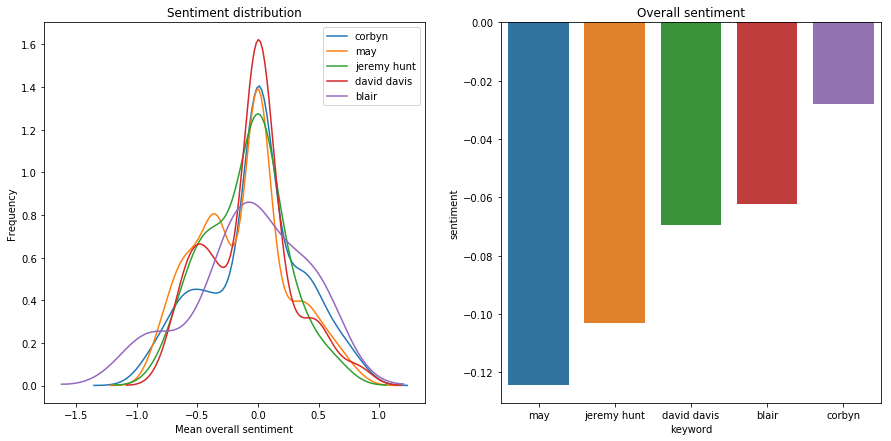

In [36]:
fig, (ax, ax1) = plt.subplots(1,2,figsize=[15,7])

for i in range(len(keywords)):
    sns.distplot(list_of_output_dfs[i]['compound'].astype(float), hist=False, label=keywords[i], ax=ax)

sns.barplot(top_level_result_df['keyword'], top_level_result_df['sentiment'], ax=ax1)
    
ax.autoscale()
ax.set_xlabel('Mean overall sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Sentiment distribution')
ax.legend()

ax1.set_title('Overall sentiment')

plt.show()